In [4]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import plotly.express as px

In [36]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api
import mlflow
import numpy as np
import pandas as pd
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
def get_data(tag, path='data/AdSmartABdata.csv', repo='G:/10_academy/Week_2/solutions/Ad_campaign_performance'):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [9]:
browser=get_data('v3')
browser.head()

,auction_id,experiment,date,hour,device_make,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,Chrome Mobile,0,1
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,Facebook,1,0
4,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,Chrome Mobile,0,1


In [10]:
browser['aware'] = browser['yes'].map(lambda x: x==1)
browser = browser.drop(columns = ['yes', 'no', 'auction_id'], axis=1)

In [11]:
browser.head()

,experiment,date,hour,device_make,browser,aware
0,exposed,2020-07-05,2,E5823,Chrome Mobile WebView,False
1,exposed,2020-07-04,16,Generic Smartphone,Chrome Mobile,True
2,exposed,2020-07-06,8,Generic Smartphone,Chrome Mobile,False
3,control,2020-07-08,4,Samsung SM-A202F,Facebook,True
4,control,2020-07-03,15,Generic Smartphone,Chrome Mobile,False


#### Label Encoding

In [16]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(df['experiment'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])


    
    return df

In [17]:
encode_labels(browser)

,experiment,date,hour,device_make,browser,aware
0,1,2,2,4,2,0
1,1,1,16,13,1,1
2,1,3,8,13,1,0
3,0,5,4,43,4,1
4,0,0,15,13,1,0
...,...,...,...,...,...,...
1238,1,2,21,13,1,1
1239,1,1,1,13,1,1
1240,0,6,7,13,1,0
1241,0,7,16,13,1,0


In [23]:
## read model
def read_model(file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        return pickle.load(f)
## save model
def write_model(file_name, model):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        pickle.dump(model, f)

In [24]:
##loss function
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


###   Logestic Regression Model training

In [40]:
class LogesticRegressionModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, model_name="LR"):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name
        
        self.clf = LogisticRegression()
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        model_name= self.model_name
        mlflow.end_run()
        for i in range(folds):

            train_index, valid_index = next(iterator)

            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]

            self.clf = self.clf.fit(X_train, y_train)

            vali_pred = self.clf.predict(X_valid)

            accuracy = self.calculate_score(y_valid, vali_pred)
            loss = loss_function(y_valid, vali_pred)

            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()

            acc_arr.append(accuracy)
            loss_arr.append(loss)
            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(self.y_test, y_pred)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss, report, matrix 
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of LogesticRegression is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of LogesticRegression is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    
    def get_p_values(self):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
    
    def plot_pvalues(self, p_df):
        
        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot([0.05,0.05], [0.05,5])
        sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
        plt.title("P values of features", size=20)

        plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()
        return fig


In [48]:
import datetime
Current_Date = datetime.datetime.today()

mlflow.set_experiment('ML_Approach_ABTEST_Browser_logestic-' + str(Current_Date))

INFO: 'ML_Approach_ABTEST_Browser_logestic-2021-07-24 13:06:54.916537' does not exist. Creating a new experiment


In [49]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser[feature_cols]
y = browser[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [50]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

write_model('browser_Logestic_Reg_model', clf2)


step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



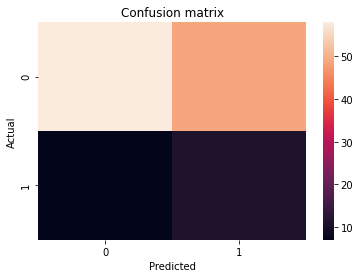

In [51]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

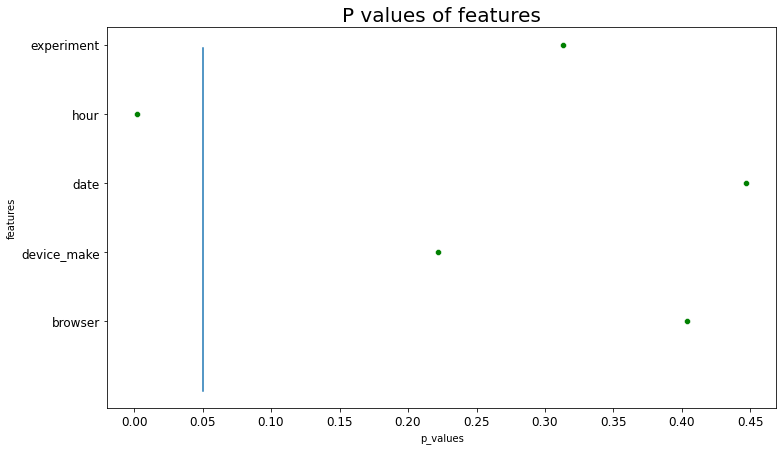

,features,p_values
0,experiment,0.313093
1,hour,0.002316
2,date,0.446756
3,device_make,0.221776
4,browser,0.403688


In [52]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df


In [53]:
mlflow.end_run()
with mlflow.start_run(run_name="Browser-DF-Logestic-Reg"):
    mlflow.log_param('Features', X_train.columns.to_list())
    mlflow.log_param('Target', y_train.columns.to_list())
    mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
    mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
    mlflow.log_param('Fold number', folds)
    
    mlflow.log_metric('Validation Accuray', acc_arr_2[-1])
    mlflow.log_metric('Validation Loss', acc_arr_2[-1])
    mlflow.log_metric('Test accuracy', test_acc2)
    mlflow.log_metric('Test Loss MSE', test_loss2)
    
    mlflow.log_figure(p_value_fig, 'fig.png')



### Decision Tree model training

In [18]:
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)


        

In [19]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser[feature_cols]
y = browser[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [25]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)

write_model('browser_decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.531
step 1: Validation Loss of DecisionTreesModel is: 0.685

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660



#### Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675



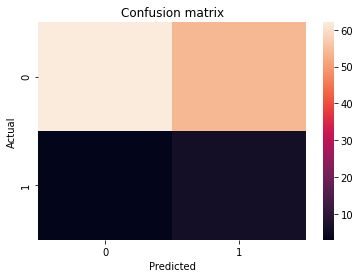

In [27]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()


#### Calculating feature importance

In [29]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.401460
2,date,0.054408
3,device_make,0.336032
4,browser,0.208099


#### Visualzing feature importance

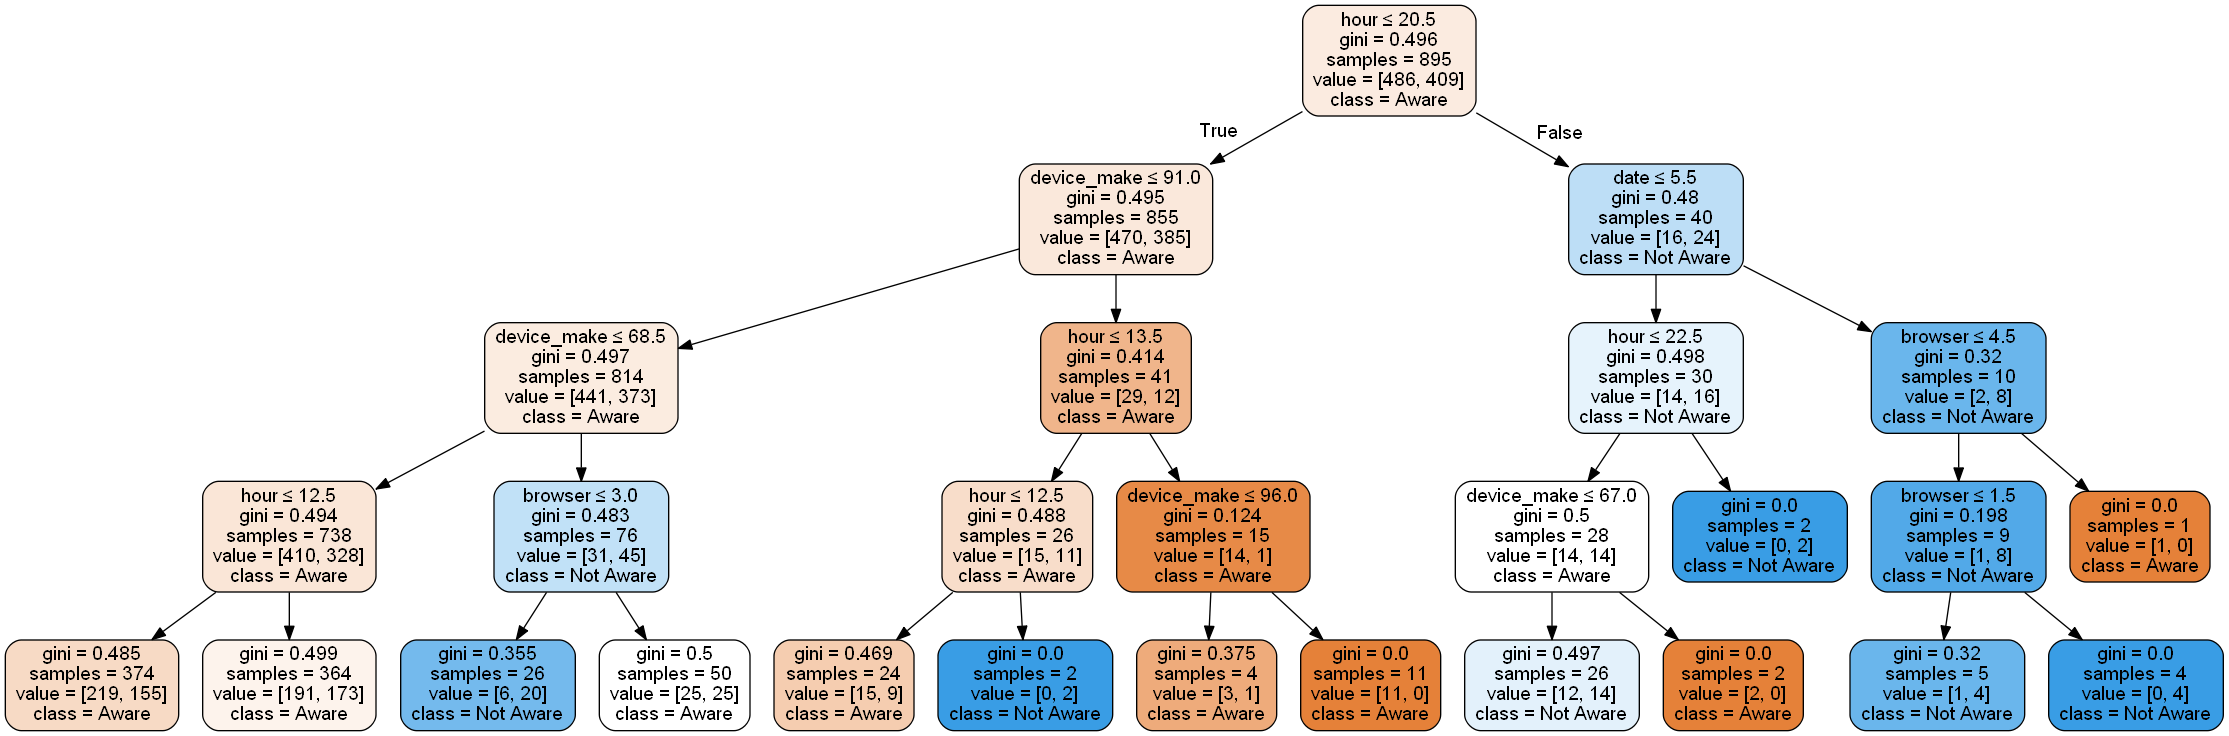

In [31]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())


This output show us that the users grouped as exposed or controld doesn't have an effect on the brand awereness.